# Computer Vision Project - Face Recognition

# PART A

### DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done. Since there higher time complexity is involved in the 

• DATA DESCRIPTION: The dataset comprises of images and its mask for corresponding human face.

• PROJECT OBJECTIVE: To build a face detection system.

### 1. Import and Understand the data 

In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [3]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2

### Q1 A. Import and read ‘images.npy’.

In [6]:
import numpy as np
import pandas as pd
import os
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import random
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

In [7]:
data = np.load('Images.npy',allow_pickle=True)

In [8]:
data[0][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}],
  'imageWidth': 650,
  'imageHeight': 333}]

### Q1.B. Split the data into Features(X) & labels(Y). Unify shape of all the images.

Imp Note: Replace all the pixels within masked area with 1.

Hint: X will comprise of array of image whereas Y will comprise of coordinates of the mask(human face). Observe: data[0], data[0][0], data[0][1].


In [9]:
IMAGE_HEIGHT =  IMAGE_WIDTH = 224

In [10]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
        img = img[:, :, :3]
    except:
        continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Q1.C Split the data into train and test[400:9].

In [11]:
X_train = X[:400]
y_train = masks[:400]

In [12]:
X_test = X[400:]
y_test = masks[400:]

In [13]:
print(X_train.shape)
print(X_test.shape)

(400, 224, 224, 3)
(9, 224, 224, 3)


In [14]:
print(y_train.shape)
print(y_test.shape)

(400, 224, 224)
(9, 224, 224)


In [15]:
len(X_train)

400

### Q1.D. Select random image from the train data and display original image and masked image.

107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


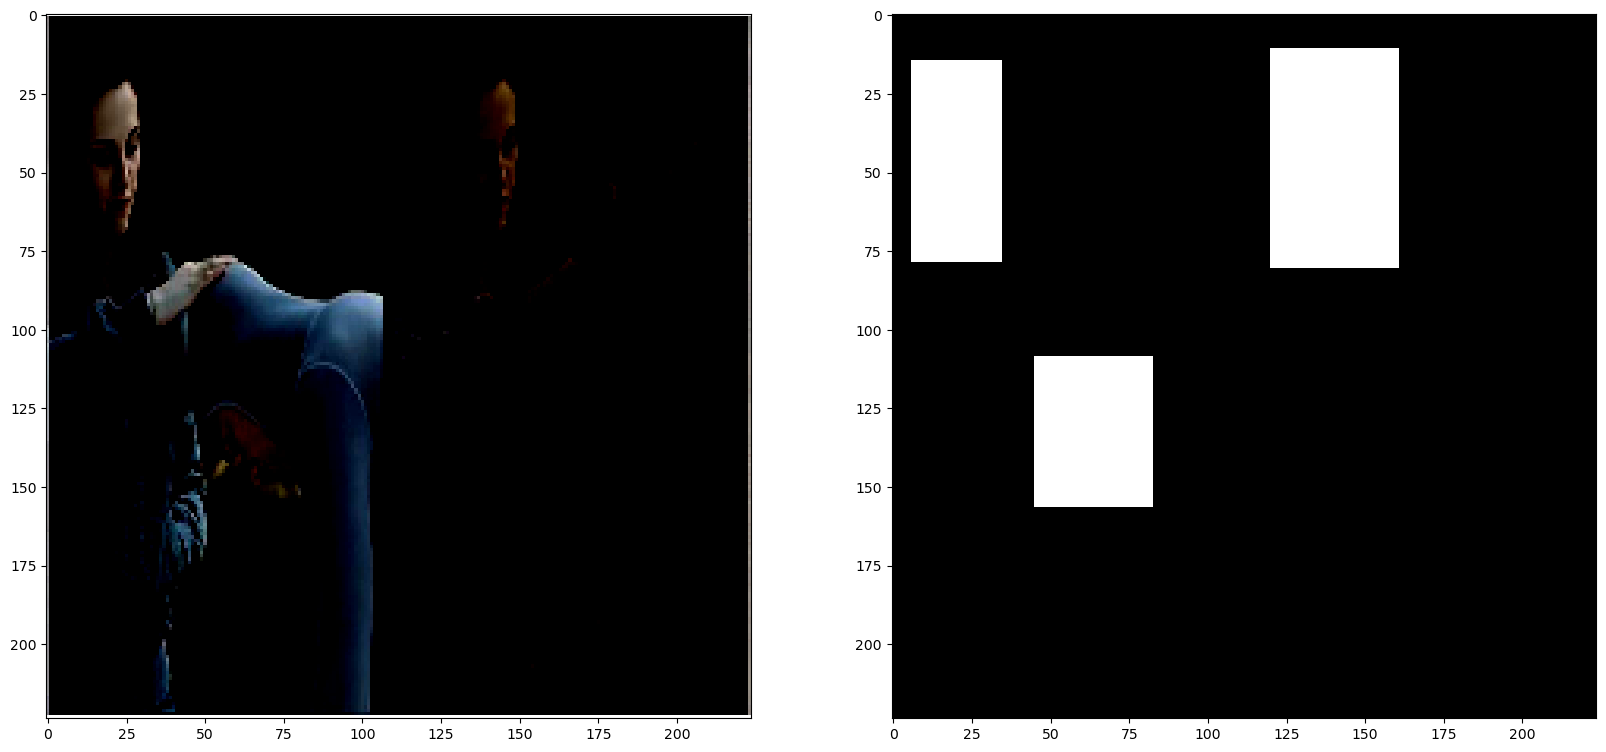

In [16]:
n = random.choice(range(len(X_train)))
print(n)
plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.imshow(X_train[n],cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(masks[n],cmap='gray')

plt.show()

## 2. Model building

### Q2A. Design a face mask detection model.
Hint: 1. Use MobileNet architecture for initial pre-trained non-trainable layers.

Hint: 2. Add appropriate Upsampling layers to imitate U-net architecture.

In [17]:
# from tensorflow.keras.applications.mobilenet_v2 import MobileNet
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [18]:
model = create_model()

(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

                                                                                                  
 conv_pw_5 (Conv2D)          (None, 28, 28, 256)          65536     ['conv_dw_5_relu[0][0]']      
                                                                                                  
 conv_pw_5_bn (BatchNormali  (None, 28, 28, 256)          1024      ['conv_pw_5[0][0]']           
 zation)                                                                                          
                                                                                                  
 conv_pw_5_relu (ReLU)       (None, 28, 28, 256)          0         ['conv_pw_5_bn[0][0]']        
                                                                                                  
 conv_pad_6 (ZeroPadding2D)  (None, 29, 29, 256)          0         ['conv_pw_5_relu[0][0]']      
                                                                                                  
 conv_dw_6

 conv_pw_10_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_pw_10_bn[0][0]']       
                                                                                                  
 conv_dw_11 (DepthwiseConv2  (None, 14, 14, 512)          4608      ['conv_pw_10_relu[0][0]']     
 D)                                                                                               
                                                                                                  
 conv_dw_11_bn (BatchNormal  (None, 14, 14, 512)          2048      ['conv_dw_11[0][0]']          
 ization)                                                                                         
                                                                                                  
 conv_dw_11_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_dw_11_bn[0][0]']       
                                                                                                  
 conv_pw_1

__________________________________________________________________________________________________


### Q2. B. Design your own Dice Coefficient and Loss function.

In [20]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

In [21]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Q2.  C. Train and tune the model as required.

In [22]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [24]:
model.fit(X_train, y_train, epochs=10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 1.2276 - dice_coefficient: 0.5114
Epoch 1: loss improved from inf to 1.22761, saving model to model-1.23.h5
400/400 [==============================] - 661s 2s/step - loss: 1.2276 - dice_coefficient: 0.5114 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.8549 - dice_coefficient: 0.6035 
Epoch 2: loss improved from 1.22761 to 0.85488, saving model to model-0.85.h5
400/400 [==============================] - 4056s 10s/step - loss: 0.8549 - dice_coefficient: 0.6035 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.7036 - dice_coefficient: 0.6539
Epoch 3: loss improved from 0.85488 to 0.70358, saving model to model-0.70.h5
400/400 [==============================] - 638s 2s/step - loss: 0.7036 - dice_coefficient: 0.6539 - lr: 0.0010
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 0.6268 - dice_coefficient: 0.6838 
Epoch 4: loss imp

### Q2. D. Evaluate and share insights on performance of the model.

In [25]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 56s 56s/step - loss: 0.9354 - dice_coefficient: 0.5575


[0.9354426860809326, 0.5575433373451233]

- As per performance tested on test images, Loss is 0.94 and dice_coefficient is 0.56.Which is not best score for sure, but has scope for improvement.
- First step to improve performance would be to randomize the images for training since test images could be part of single class and which could generate biased results.

## Q3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.

In [26]:
tst_img = X_test[3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


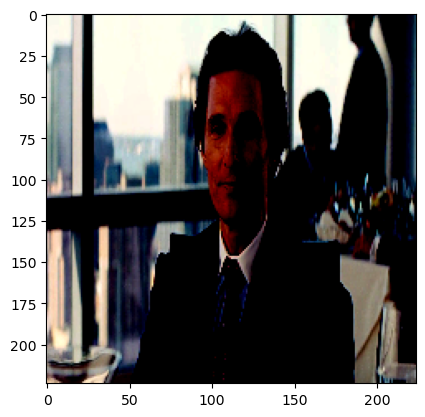

In [27]:
plt.imshow(tst_img)

In [28]:
tst_img = cv2.resize(tst_img,(IMAGE_HEIGHT,IMAGE_WIDTH))

In [29]:
tst_img.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


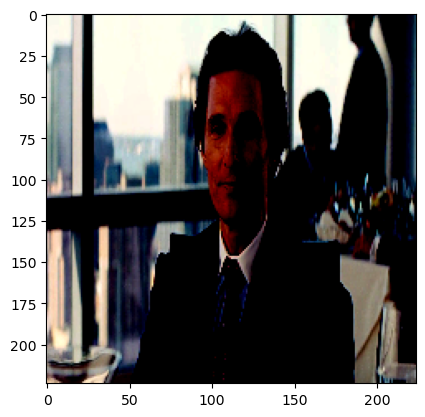

In [30]:
plt.imshow(tst_img)

In [31]:
tst_img_1 = np.expand_dims(tst_img,0)

In [32]:
pred_mask = 1.0 * (model.predict(tst_img_1))

1/1 [==============================] - 2s 2s/step


In [33]:
pred_mask = pred_mask.swapaxes(0,1)
pred_mask = pred_mask.swapaxes(1,2)

In [34]:
pred_mask.shape

(224, 224, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


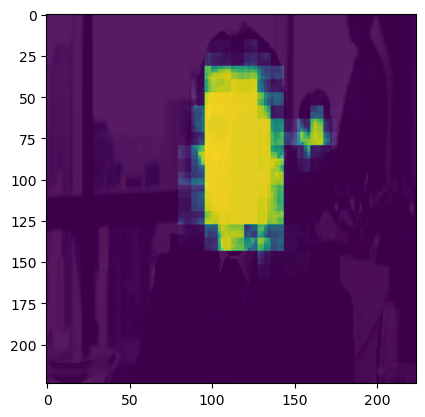

In [35]:
plt.imshow(tst_img)
plt.imshow(pred_mask,alpha=0.9)

# 

# PART B

## DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done.

• DATA DESCRIPTION: The dataset comprises of face images.

• PROJECT OBJECTIVE: To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

### Q1. Read/import images from folder ‘training_images’.

In [36]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [37]:
import cv2 # Open cv version 2
import os
import glob
img_dir = "training_images/" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g') # '*' is used to extract all files in the directory
files = glob.glob(data_path)
data = []  # EMPTY LIST
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)

In [38]:
dir_list = next(os.walk(img_dir))[2]
dir_list

['real_00001.jpg',
 'real_00002.jpg',
 'real_00003.jpg',
 'real_00004.jpg',
 'real_00005.jpg',
 'real_00006.jpg',
 'real_00007.jpg',
 'real_00008.jpg',
 'real_00009.jpg',
 'real_00010.jpg',
 'real_00011.jpg',
 'real_00012.jpg',
 'real_00013.jpg',
 'real_00014.jpg',
 'real_00015.jpg',
 'real_00016.jpg',
 'real_00017.jpg',
 'real_00018.jpg',
 'real_00019.jpg',
 'real_00020.jpg',
 'real_00021.jpg',
 'real_00022.jpg',
 'real_00023.jpg',
 'real_00024.jpg',
 'real_00025.jpg',
 'real_00026.jpg',
 'real_00027.jpg',
 'real_00028.jpg',
 'real_00029.jpg',
 'real_00030.jpg',
 'real_00031.jpg',
 'real_00032.jpg',
 'real_00033.jpg',
 'real_00034.jpg',
 'real_00035.jpg',
 'real_00036.jpg',
 'real_00037.jpg',
 'real_00038.jpg',
 'real_00039.jpg',
 'real_00040.jpg',
 'real_00041.jpg',
 'real_00042.jpg',
 'real_00043.jpg',
 'real_00044.jpg',
 'real_00045.jpg',
 'real_00046.jpg',
 'real_00047.jpg',
 'real_00048.jpg',
 'real_00049.jpg',
 'real_00050.jpg',
 'real_00051.jpg',
 'real_00052.jpg',
 'real_00053

### Q2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.

Hint: You can use ’haarcascade_frontalface_default.xml’ from internet to detect faces which is available open source.

In [39]:
x_cord=[]
y_cord=[]
height=[]
width=[]
face_detected=[]
image_name=[]

In [40]:
import cv2 # Open cv version 2

for i in range (len(dir_list)):
    print("Execution loop=",i)
    # Create a cascade classfier object
    # face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'FF_Default.xml')
    face_cascade = cv2.CascadeClassifier("FF_Default.xml")   # frontal face 
    data_path = os.path.join(img_dir,dir_list[i])
    img=cv2.imread(data_path)
    faces=face_cascade.detectMultiScale(img,scaleFactor=1.05,minNeighbors=5)
    # faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    j=0 

    # Find coordinates of the face
    for x,y,w,h in faces:
        img=cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 0),2)
        j=j+1
    resized=cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0])))
    
    length=len(faces)
    if length==0:
        a=0
        b=0
        c=0
        d=0
        j=0
        name=0
        
    else:
        a=faces[0,0]
        b=faces[0,1]
        c=faces[0,2]
        d=faces[0,3]
        name=dir_list[i]
        
    
    x_cord.append(a)
    y_cord.append(b)
    width.append(c)
    height.append(d)
    face_detected.append(j)
    image_name.append(name)

Execution loop= 0


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


### Q3. From the same loop above, extract metadata of the faces and write into a DataFrame.

In [41]:
import pandas as pd

DB = pd.DataFrame(x_cord, columns = ['x'])

DB['y']=y_cord
DB['w']=width
DB['h']=height
DB['Total_Faces']=face_detected
DB['Image_Name']=image_name

DB.head()

,x,y,w,h,Total_Faces,Image_Name


### Q4. Save the output Dataframe in .csv format. 

In [42]:
DB.to_csv("Bounding boxes.csv")

# 

# PART C

## DOMAIN: Face Recognition

• CONTEXT: Company X intends to build a face identification model to recognise human faces.

• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

• PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library.

## 1. Unzip, read and Load data(‘PINS.zip’) into session.

In [43]:
import zipfile
from zipfile import ZipFile

In [44]:
import zipfile
with zipfile.ZipFile('PINS.zip', 'r') as zip:
    zip.extractall()

## Q2. Write function to create metadata of the image.
Hint: Metadata means derived information from the available data which can be useful for particular problem statement.

In [45]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 

## Q3. Write a loop to iterate through each and every image and create metadata for all the images.

In [46]:
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [47]:
metadata = load_metadata('PINS')

In [48]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [49]:
load_image(metadata[0].image_path())

array([[[233, 188, 165],
        [231, 186, 163],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[232, 187, 164],
        [233, 188, 165],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[230, 186, 161],
        [228, 184, 159],
        [206, 164, 140],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       ...,

       [[198, 118,  91],
        [197, 120,  94],
        [195, 119,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[200, 120,  93],
        [200, 120,  93],
        [198, 121,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[201, 121,  94],
        [201, 121,  94],
        [199, 122,  96],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]]

## Q4. Generate Embeddings vectors on the each face in the dataset. 
### Hint: Use ‘vgg_face_weights.h5’

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [51]:
from tensorflow.keras.models import model_from_json
model = vgg_face()
model.load_weights('vgg_face_weights.h5')

In [53]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [54]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
(2622,)


In [55]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        # scale RGB values to interval [0,1]
        img = cv2.resize(img, dsize = (224,224))
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    except Exception as e:
        print(str(e))
        print(i,m)

1/1 [==============================] - 1s 761ms/step


1/1 [==============================] - 1s 753ms/step


1/1 [==============================] - 1s 761ms/step


1/1 [==============================] - 1s 762ms/step


1/1 [==============================] - 1s 937ms/step


1/1 [==============================] - 1s 755ms/step


1/1 [==============================] - 1s 760ms/step


1/1 [==============================] - 1s 759ms/step


1/1 [==============================] - 1s 755ms/step


1/1 [==============================] - 1s 766ms/step


1/1 [==============================] - 1s 758ms/step


1/1 [==============================] - 1s 759ms/step


1/1 [==============================] - 1s 762ms/step


1/1 [==============================] - 1s 759ms/step


1/1 [==============================] - 1s 759ms/step


1/1 [==============================] - 1s 764ms/step


1/1 [==============================] - 1s 763ms/step


1/1 [==============================] - 1s 763ms/step


1/1 [==============================] - 1s 763ms/step


1/1 [==============================] - 1s 765ms/step


1/1 [==============================] - 1s 763ms/step


1/1 [==============================] - 1s 768ms/step


1/1 [==============================] - 1s 762ms/step


1/1 [==============================] - 1s 771ms/step


1/1 [==============================] - 1s 764ms/step


1/1 [==============================] - 1s 817ms/step


1/1 [==============================] - 1s 776ms/step


1/1 [==============================] - 1s 766ms/step


1/1 [==============================] - 1s 764ms/step


1/1 [==============================] - 1s 769ms/step


1/1 [==============================] - 1s 788ms/step


1/1 [==============================] - 1s 772ms/step


1/1 [==============================] - 1s 772ms/step


1/1 [==============================] - 1s 768ms/step


1/1 [==============================] - 1s 773ms/step


1/1 [==============================] - 1s 775ms/step


1/1 [==============================] - 1s 772ms/step


1/1 [==============================] - 1s 776ms/step


1/1 [==============================] - 1s 783ms/step


1/1 [==============================] - 1s 775ms/step


1/1 [==============================] - 1s 781ms/step


1/1 [==============================] - 1s 778ms/step


1/1 [==============================] - 1s 777ms/step


1/1 [==============================] - 1s 779ms/step


1/1 [==============================] - 1s 775ms/step


1/1 [==============================] - 1s 779ms/step


1/1 [==============================] - 1s 779ms/step


1/1 [==============================] - 1s 774ms/step


1/1 [==============================] - 1s 776ms/step


1/1 [==============================] - 1s 777ms/step


1/1 [==============================] - 1s 788ms/step


1/1 [==============================] - 1s 789ms/step


1/1 [==============================] - 1s 782ms/step


1/1 [==============================] - 1s 785ms/step


1/1 [==============================] - 1s 782ms/step


1/1 [==============================] - 1s 780ms/step


1/1 [==============================] - 1s 924ms/step


1/1 [==============================] - 1s 790ms/step


1/1 [==============================] - 1s 783ms/step


1/1 [==============================] - 1s 792ms/step


1/1 [==============================] - 1s 792ms/step


1/1 [==============================] - 1s 786ms/step


1/1 [==============================] - 1s 793ms/step


1/1 [==============================] - 1s 788ms/step


1/1 [==============================] - 1s 795ms/step


1/1 [==============================] - 1s 801ms/step


1/1 [==============================] - 1s 792ms/step


1/1 [==============================] - 1s 792ms/step


1/1 [==============================] - 1s 817ms/step


1/1 [==============================] - 1s 793ms/step


## Q5. Build distance metrics for identifying the distance between two similar and dissimilar images. 

In [56]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

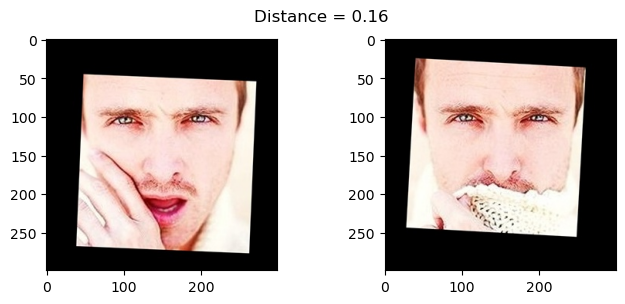

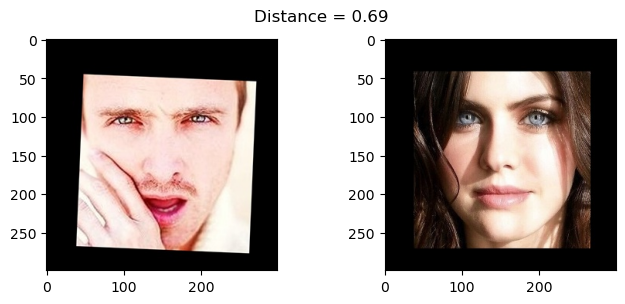

In [57]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

## Q6. Use PCA for dimensionality reduction.

In [58]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
y_train = targets[train_idx]
y_test = targets[test_idx]

In [59]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Numerical encoding of identities
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [60]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## Q7. Build an SVM classifier in order to map each image to its right person. 

In [62]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9615705931495405

## Q8. Import and display the the test images.
### Hint: ‘Benedict Cumberbatch9.jpg’ and ‘Dwayne Johnson4.jpg’ are the test images.

In [63]:
rock = cv2.imread('Dwayne Johnson4.jpg')
dr_strange = cv2.imread('Benedict Cumberbatch9.jpg')

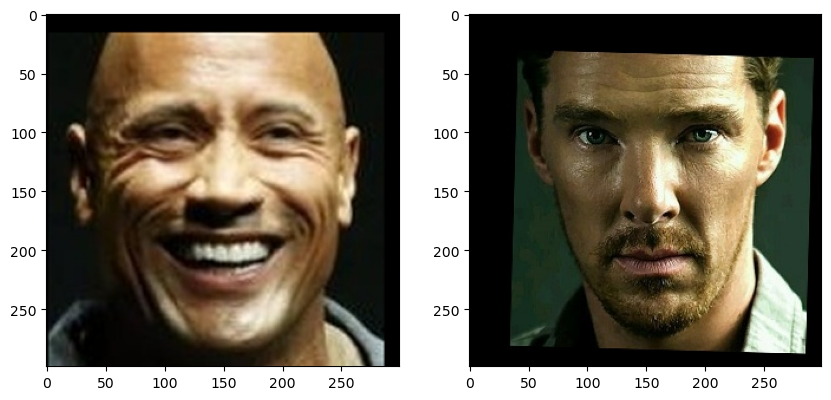

In [64]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(rock[...,::-1])
plt.subplot(122)
plt.imshow(dr_strange[...,::-1])

## Q9. Use the trained SVM model to predict the face on both test images.

In [65]:
img = load_image('Dwayne Johnson4.jpg')
img = cv2.resize(img, dsize = (224,224))
img = (img / 255.).astype(np.float32)

In [66]:
def preprocess_test_img(path_to_img):
    orig_img = load_image(path_to_img)
    img = cv2.resize(orig_img, dsize = (224,224))
    img = (img / 255.).astype(np.float32)
    img = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    img = np.expand_dims(img,0)
    img = sc.transform(img)
    img = pca.transform(img)
    return orig_img,img

1/1 [==============================] - 4s 4s/step


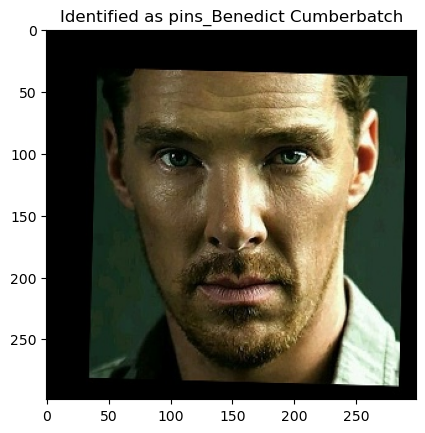

In [67]:
orig_img, tst_img = preprocess_test_img('Benedict Cumberbatch9.jpg')
pred = clf.predict(tst_img)
ret = encoder.inverse_transform(pred)[0]
plt.imshow(orig_img)
plt.title(f'Identified as {ret}');

1/1 [==============================] - 1s 817ms/step


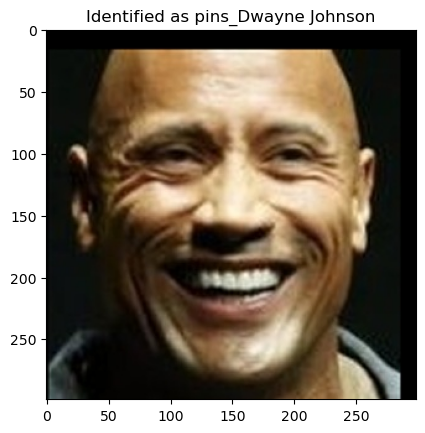

In [68]:
orig_img, tst_img = preprocess_test_img('Dwayne Johnson4.jpg')
pred = clf.predict(tst_img)
ret = encoder.inverse_transform(pred)[0]
plt.imshow(orig_img)
plt.title(f'Identified as {ret}');

# 

# 